<a href="https://colab.research.google.com/github/RazorPG/cluster-produk-berdasarkan-harga-dan-implikasi-diskon/blob/main/kmeans_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP IMPORT

In [38]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import MinMaxScaler
from google.colab import files
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
files.upload()

{}

# SETUP KAGGLE API

In [39]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# UNDUH DATASET TRANSAKSI DARI KAGGLE

In [40]:
!kaggle datasets download -d steve1215rogg/e-commerce-dataset
!unzip e-commerce-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/steve1215rogg/e-commerce-dataset
License(s): CC-BY-NC-SA-4.0
e-commerce-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  e-commerce-dataset.zip
replace ecommerce_dataset_updated.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# MULAI SPARK SESSION

In [41]:
spark = SparkSession.builder.appName("KMeans Parallel Clustering").config('spark.memory.offHeap.size', "10g").getOrCreate()

# BACA DATASET

In [42]:
df = spark.read.csv("ecommerce_dataset_updated.csv", header=True, inferSchema=True)
df.printSchema()
df.count()

root
 |-- User_ID: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Price (Rs.): double (nullable = true)
 |-- Discount (%): integer (nullable = true)
 |-- Final_Price(Rs.): double (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- Purchase_Date: string (nullable = true)



3660

# RENAME KOLOM

In [44]:
df = df.withColumnRenamed("Price (Rs.)", "Price") \
.withColumnRenamed("Discount (%)", "Discount") \
.withColumnRenamed("Final_Price(Rs.)", "Final_Price")

# AMBIL DATA KOLOM YANG DIBUTUHKAN

In [45]:
assembler = VectorAssembler(
    inputCols=["Price", "Final_Price"],
    outputCol="features"
)

data_features = assembler.transform(df)

# FEATURE SCALLING

In [46]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(data_features)
data_scaled = scalerModel.transform(data_features)

# JUMLAH K TERBAIK DENGAN ELBOW METHOD

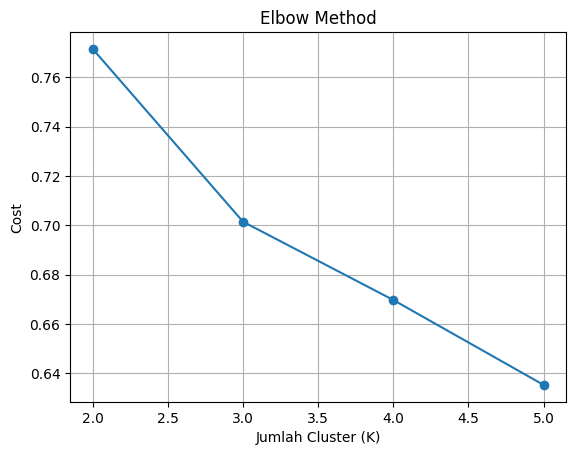

In [47]:
cost = []
for k in range(2, 6):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k, seed=42)
    model = kmeans.fit(data_scaled)
    predictions = model.transform(data_scaled)
    evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    cost.append((k, silhouette))

# visualisasi
x, y = zip(*cost)
plt.plot(x, y, marker='o')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Cost')
plt.grid(True)
plt.title('Elbow Method')
plt.show()

# K-MEANS CLUSTERING

In [48]:
kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(data_scaled)
centers = model.clusterCenters()
centers

[array([0.50345675, 0.40024398]),
 array([0.16528125, 0.13415697]),
 array([0.82923219, 0.69377008])]

# PREDIKSI CLUSTER



In [52]:
predictions = model.transform(data_scaled)
predictions.groupBy("prediction").agg({"Price": "avg", "Discount": "avg"}).collect()

[Row(prediction=1, avg(Discount)=20.132450331125828, avg(Price)=91.05632450331117),
 Row(prediction=2, avg(Discount)=16.34297520661157, avg(Price)=416.30597520661144),
 Row(prediction=0, avg(Discount)=19.97181964573269, avg(Price)=256.7183574879226)]

# LABEL DARI CLUSTER

In [57]:
predictions = predictions.withColumn("Label", when(col("prediction") == 0, "Harga Reguler")
                                      .when(col("prediction") == 1, "Harga Ekonomis")
                                      .when(col("prediction") == 2, "Harga Mahal"))
predictions.select("Price", "Discount", "Final_Price", "prediction", "Label").show()

+------+--------+-----------+----------+--------------+
| Price|Discount|Final_Price|prediction|         Label|
+------+--------+-----------+----------+--------------+
| 36.53|      15|      31.05|         1|Harga Ekonomis|
|232.79|      20|     186.23|         0| Harga Reguler|
|317.02|      25|     237.76|         0| Harga Reguler|
|173.19|      25|     129.89|         1|Harga Ekonomis|
| 244.8|      20|     195.84|         0| Harga Reguler|
|241.86|      50|     120.93|         0| Harga Reguler|
| 76.91|       5|      73.06|         1|Harga Ekonomis|
|213.23|      20|     170.58|         0| Harga Reguler|
|379.81|       5|     360.82|         2|   Harga Mahal|
|415.36|      50|     207.68|         2|   Harga Mahal|
| 73.09|      10|      65.78|         1|Harga Ekonomis|
|393.77|      15|      334.7|         2|   Harga Mahal|
|287.69|      10|     258.92|         0| Harga Reguler|
| 26.26|      50|      13.13|         1|Harga Ekonomis|
| 305.1|      25|     228.83|         0| Harga R

# VISUALISASI HASIL CLUSTER

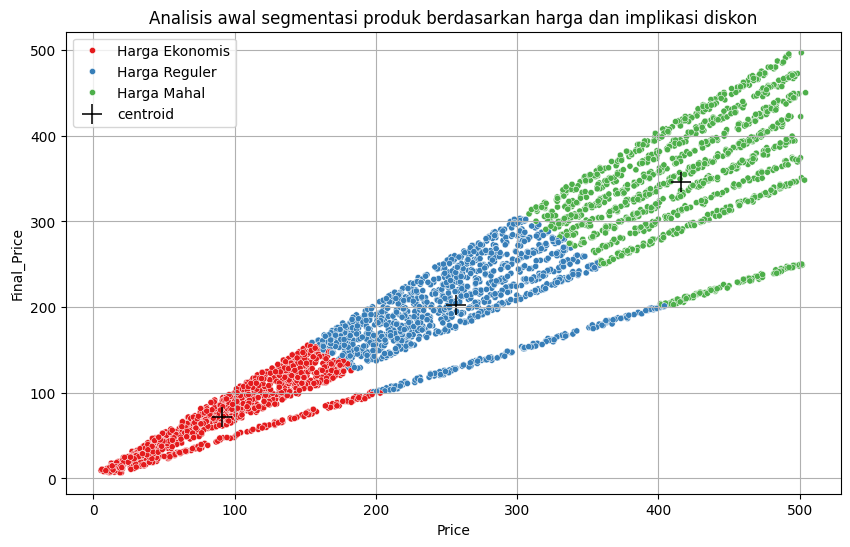

In [60]:
centers_unscaled = np.array(centers) * (scalerModel.originalMax.toArray() - scalerModel.originalMin.toArray()) + scalerModel.originalMin.toArray()
pdf = predictions.select("Price", "Discount", "Final_Price", "Label").toPandas()

pdf['Price'] = pdf['Price'] + np.random.uniform(-5, 5, size=len(pdf))
pdf['Final_Price'] = pdf['Final_Price'] + np.random.uniform(-1, 1, size=len(pdf))


plt.figure(figsize=(10, 6))
sns.scatterplot(x="Price", y="Final_Price", hue="Label", data=pdf, palette="Set1", s=20)
sns.scatterplot(x=centers_unscaled[:, 0], y=centers_unscaled[:, 1], color="black", marker="+", s=200, label="centroid")
plt.title("Analisis awal segmentasi produk berdasarkan harga dan implikasi diskon")
plt.legend()
plt.grid()
plt.show()

In [77]:
centers_unscaled

array([[376.98488792,  14.11581569],
       [130.52278967,  14.8929471 ],
       [257.21577253,  48.45493562]])

# MATIKAN SPARK

In [76]:
spark.stop()